<a href="https://colab.research.google.com/github/edramos-lab/Datasets/blob/main/ImageRecognition_BasePlates_v1.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb -qq

In [2]:
 #Standard Libraries and OpenCV in order to manage screen
import cv2
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

#import ImageAumgentation Library
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Architecture and Optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, Dense, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

#Hyperparameters & Tensorflow library
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
import tensorflow as tf
import matplotlib.text as mpl_text
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

#Models
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2 
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard

#Reporting
import seaborn as sn
from sklearn.metrics import classification_report,confusion_matrix
import logging
import threading
import time
import datetime as dt
import wandb
from wandb.keras import WandbCallback

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



#Reporting
import seaborn as sn
from sklearn.metrics import classification_report,confusion_matrix
import logging
import threading
import time
import datetime as dt

import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10


# Set the random seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

In [4]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [5]:
cd '/content/gdrive/MyDrive'

/content/gdrive/MyDrive


In [6]:
import numpy as np
import plotly.graph_objs as go

#import keras
from wandb.keras import WandbCallback
from sklearn.metrics import confusion_matrix

class WandbClassificationCallback(WandbCallback):

    def __init__(self, monitor='val_loss', verbose=0, mode='auto',
                 save_weights_only=False, log_weights=False, log_gradients=False,
                 save_model=True, training_data=None, validation_data=None,
                 labels=[], data_type=None, predictions=1, generator=None,
                 input_type=None, output_type=None, log_evaluation=False,
                 validation_steps=None, class_colors=None, log_batch_frequency=None,
                 log_best_prefix="best_", log_confusion_matrix=False, confusion_examples=0):
        
        super().__init__(monitor=monitor,
                        verbose=verbose, 
                        mode=mode,
                        save_weights_only=save_weights_only,
                        log_weights=log_weights,
                        log_gradients=log_gradients,
                        save_model=save_model,
                        training_data=training_data,
                        validation_data=validation_data,
                        labels=labels,
                        data_type=data_type,
                        predictions=predictions,
                        generator=generator,
                        input_type=input_type,
                        output_type=output_type,
                        log_evaluation=log_evaluation,
                        validation_steps=validation_steps,
                        class_colors=class_colors,
                        log_batch_frequency=log_batch_frequency,
                        log_best_prefix=log_best_prefix)
                        
        self.log_confusion_matrix = log_confusion_matrix
        self.confusion_examples = confusion_examples
               
    def on_epoch_end(self, epoch, logs={}):
        if self.generator:
            self.validation_data = next(self.generator)

        if self.log_weights:
            wandb.log(self._log_weights(), commit=False)

        if self.log_gradients:
            wandb.log(self._log_gradients(), commit=False)
        
        if self.log_confusion_matrix:
            if self.validation_data is None:
                wandb.termwarn(
                    "No validation_data set, pass a generator to the callback.")
            elif self.validation_data and len(self.validation_data) > 0:
                wandb.log(self._log_confusion_matrix(), commit=False)

        if self.input_type in ("image", "images", "segmentation_mask") or self.output_type in ("image", "images", "segmentation_mask"):
            if self.validation_data is None:
                wandb.termwarn(
                    "No validation_data set, pass a generator to the callback.")
            elif self.validation_data and len(self.validation_data) > 0:
                wandb.log({"examples": self._log_images(
                    num_images=self.predictions)}, commit=False)

        wandb.log({'epoch': epoch}, commit=False)
        wandb.log(logs, commit=True)

        self.current = logs.get(self.monitor)
        if self.current and self.monitor_op(self.current, self.best):
            if self.log_best_prefix:
                wandb.run.summary["%s%s" % (self.log_best_prefix, self.monitor)] = self.current
                wandb.run.summary["%s%s" % (self.log_best_prefix, "epoch")] = epoch
                if self.verbose and not self.save_model:
                    print('Epoch %05d: %s improved from %0.5f to %0.5f' % (
                        epoch, self.monitor, self.best, self.current))
            if self.save_model:
                self._save_model(epoch)
            self.best = self.current
        
    def _log_confusion_matrix(self):
        x_val = self.validation_data[0]
        y_val = self.validation_data[1]
        y_val = np.argmax(y_val, axis=1)
        y_pred = np.argmax(self.model.predict(x_val), axis=1)

        confmatrix = confusion_matrix(y_pred, y_val, labels=range(len(self.labels)))
        confdiag = np.eye(len(confmatrix)) * confmatrix
        np.fill_diagonal(confmatrix, 0)

        confmatrix = confmatrix.astype('float')
        n_confused = np.sum(confmatrix)
        confmatrix[confmatrix == 0] = np.nan
        confmatrix = go.Heatmap({'coloraxis': 'coloraxis1', 'x': self.labels, 'y': self.labels, 'z': confmatrix,
                                 'hoverongaps':False, 'hovertemplate': 'Predicted %{y}<br>Instead of %{x}<br>On %{z} examples<extra></extra>'})

        confdiag = confdiag.astype('float')
        n_right = np.sum(confdiag)
        confdiag[confdiag == 0] = np.nan
        confdiag = go.Heatmap({'coloraxis': 'coloraxis2', 'x': self.labels, 'y': self.labels, 'z': confdiag,
                               'hoverongaps':False, 'hovertemplate': 'Predicted %{y} just right<br>On %{z} examples<extra></extra>'})

        fig = go.Figure((confdiag, confmatrix))
        transparent = 'rgba(0, 0, 0, 0)'
        n_total = n_right + n_confused
        fig.update_layout({'coloraxis1': {'colorscale': [[0, transparent], [0, 'rgba(180, 0, 0, 0.05)'], [1, f'rgba(180, 0, 0, {max(0.2, (n_confused/n_total) ** 0.5)})']], 'showscale': False}})
        fig.update_layout({'coloraxis2': {'colorscale': [[0, transparent], [0, f'rgba(0, 180, 0, {min(0.8, (n_right/n_total) ** 2)})'], [1, 'rgba(0, 180, 0, 1)']], 'showscale': False}})

        xaxis = {'title':{'text':'y_true'}, 'showticklabels':False}
        yaxis = {'title':{'text':'y_pred'}, 'showticklabels':False}

        fig.update_layout(title={'text':'Confusion matrix', 'x':0.5}, paper_bgcolor=transparent, plot_bgcolor=transparent, xaxis=xaxis, yaxis=yaxis)
        
        return {'confusion_matrix': wandb.data_types.Plotly(fig)}

In [7]:
import pathlib

data_dir = 'sample_data/trainingImages_original'
data_dir = pathlib.Path(data_dir)

In [8]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

11966


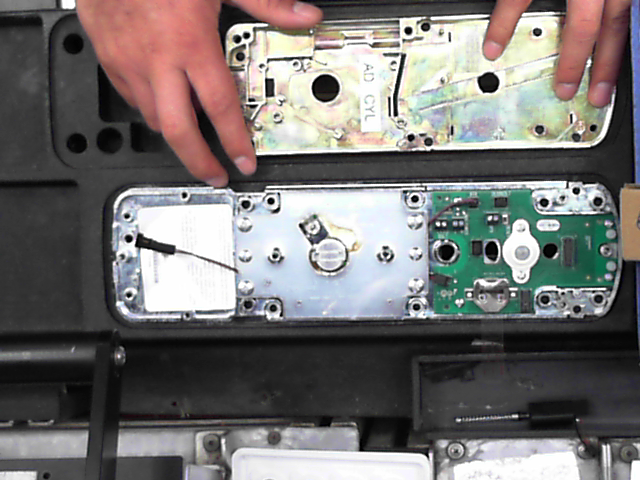

In [9]:
Class1=list(data_dir.glob('Class1/*'))
PIL.Image.open(str(Class1[0]))

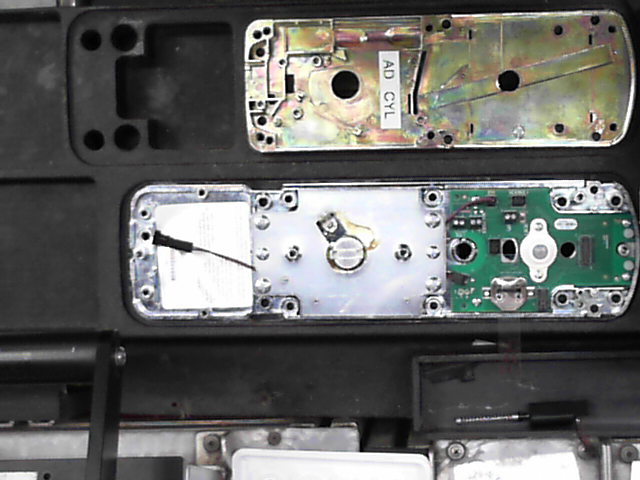

In [10]:
PIL.Image.open(str(Class1[1]))

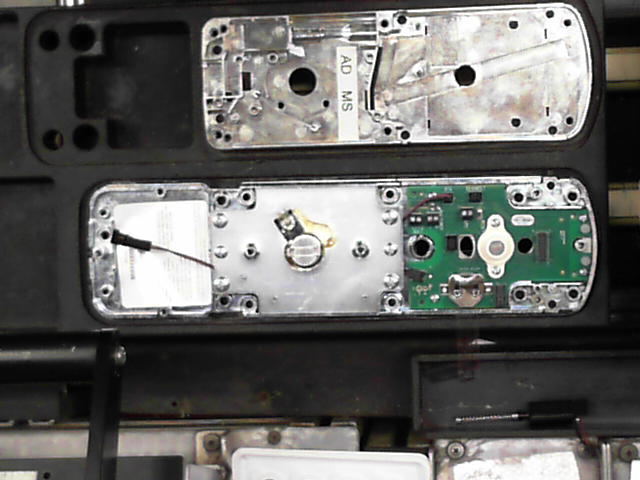

In [11]:
Class2 = list(data_dir.glob('Class2/*'))
PIL.Image.open(str(Class2[0]))

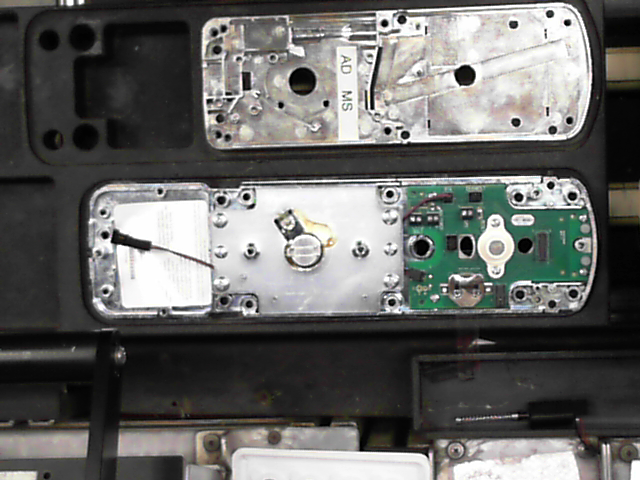

In [12]:
PIL.Image.open(str(Class2[3]))

In [13]:
batch_size = 16
img_height =200
img_width = 200

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11970 files belonging to 6 classes.
Using 9576 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11970 files belonging to 6 classes.
Using 2394 files for validation.


In [16]:
import pathlib

data_dir = 'sample_data/Baseplates/Test'
data_dir = pathlib.Path(data_dir)

In [17]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=1)

Found 60 files belonging to 6 classes.


In [18]:
class_names = train_ds.class_names
print(class_names)

['Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6']


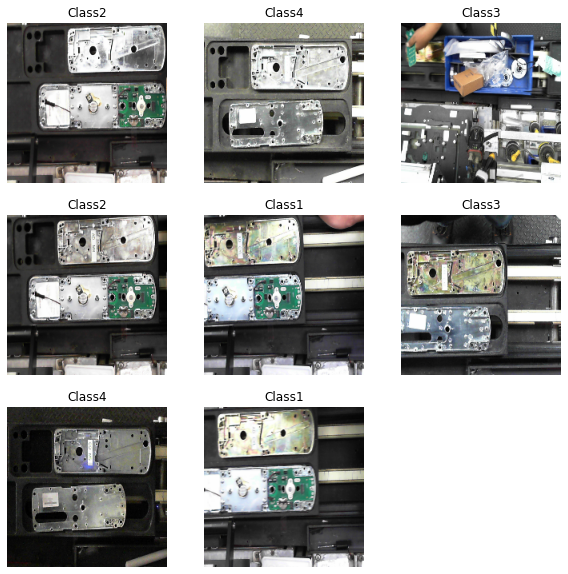

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [20]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 200, 200, 3)
(16,)


In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
normalization_layer = layers.Rescaling(1./255)

In [23]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [24]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    #layers.RandomRotation(0.20),
    layers.RandomZoom(0.2)
   
  ]
)

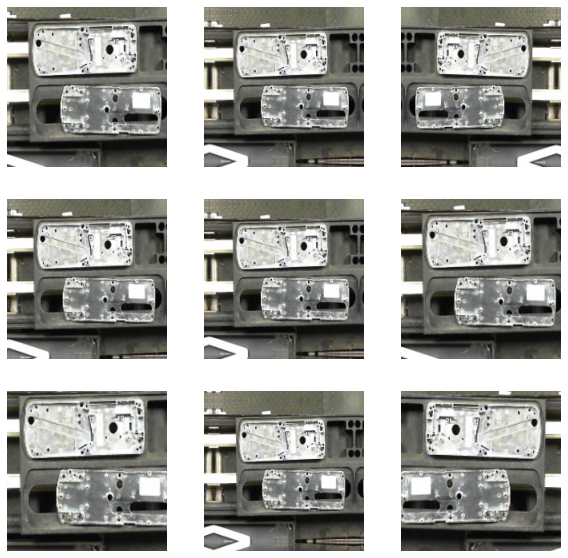

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [26]:
num_classes=6
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [27]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                  

In [29]:
run = wandb.init(project="ImageRecognition1", entity="edramos")

wandb: Currently logged in as: edramos (use `wandb login --relogin` to force relogin)


In [ ]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,callbacks=[WandbCallback()]
)

Epoch 1/100
599/599 [==============================] - 161s 217ms/step - loss: 0.6589 - accuracy: 0.7382 - val_loss: 0.2265 - val_accuracy: 0.9089
Epoch 2/100
599/599 [==============================] - 25s 42ms/step - loss: 0.2037 - accuracy: 0.9215 - val_loss: 0.1257 - val_accuracy: 0.9507
Epoch 3/100
599/599 [==============================] - 25s 41ms/step - loss: 0.1238 - accuracy: 0.9525 - val_loss: 0.1066 - val_accuracy: 0.9628
Epoch 4/100
599/599 [==============================] - 25s 41ms/step - loss: 0.0873 - accuracy: 0.9699 - val_loss: 0.0747 - val_accuracy: 0.9708
Epoch 5/100
599/599 [==============================] - 23s 39ms/step - loss: 0.0782 - accuracy: 0.9716 - val_loss: 0.1021 - val_accuracy: 0.9612
Epoch 6/100
599/599 [==============================] - 24s 41ms/step - loss: 0.0702 - accuracy: 0.9750 - val_loss: 0.0395 - val_accuracy: 0.9850
Epoch 7/100
599/599 [==============================] - 24s 40ms/step - loss: 0.0528 - accuracy: 0.9830 - val_loss: 0.0538 - val_

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('sample_data/model_saved_11162021-920.hdf5')

In [ ]:
from keras.models import load_model
 
model = load_model('sample_data/model_saved_11162021-920.hdf5')

In [ ]:

test_data_dir = 'sample_data/Baseplates/Test'
test_data_dir = pathlib.Path(test_data_dir)

In [ ]:
image_count = len(list(test_data_dir.glob('*/*.png')))
print(image_count)

In [ ]:
Class=list(test_data_dir.glob('Class4/*'))
PIL.Image.open(str(Class[1]))

In [ ]:
import cv2
file=str(Class[1])
img = cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2RGB)

img = cv2.resize(img, (img_width,img_height))



test_image = img_to_array(img)

test_image = np.expand_dims(test_image, axis=0)

pred = model.predict(test_image)

In [ ]:
print(pred, class_names[np.argmax(pred)])

In [ ]:
test_data_path='sample_data/Baseplates/Test/'

In [ ]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_data_path, # Put your path here
     target_size=(img_height,img_width),
    batch_size=1, class_mode='categorical',
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

#predictions = model.predict(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
#predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
#Plot the confusion matrix. Set Normalize = True/False



def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')



In [ ]:
#Confution Matrix 
import itertools 
Y_pred = model.predict(test_data_generator)

y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')

cm = confusion_matrix(test_data_generator.classes, y_pred)

plot_confusion_matrix(cm, class_names, title='Confusion Matrix')

In [ ]:
# Confusion Matrices
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())  

In [ ]:
report = classification_report(true_classes, y_pred, target_names=class_names)
print(report)    

In [ ]:
confusion_matrix(true_classes, predicted_classes)

In [ ]:
# Confusion Matrices
wandb.sklearn.plot_confusion_matrix(true_classes, predicted_classes, class_names)